# Real-time aggregation with atoti

## Introduction

In our example we will create a real-time risk dashboard using atoti. We will explore the three methods for real-time updates: 

- monitoring **file updates**, 
- the **append** method and 
- subscribing to a **kafka feed** with a custom serializer.

Using a finance use case as an example, we are going to perform the following:
- simulate a live feed of market quotes 
- use QuantLib to recalculate sensitivities on the fly
- stream updated risk numbers to an atoti-powered in-memory cube which will update our risk dashboard. 
- we will emulate real-time trading activity: every time a new trade arrives from kafka, a live "trades_blotter" widget in atoti app will blink to reflect the updates of measurements due to the new records. 

Have a look at the GIF of the running atoti application below. On the left, we have a real-time market data feed which is a replay of historical stock prices. On the bottom, there are our trades and on the right, we have risk data continuously re-calculated and re-aggregated at various levels. Every time market data is updated, a chain of actions is performed automatically, resulting in an update to the risk summary table. With this in mind, let’s dive deep into the details!

<img src="./img/app-preview.gif" alt="Real-time risk app preview" width="75%">

# Imports

In [1]:
# !conda install -c conda-forge python-wget -y

In [2]:
# !pip install atoti[kafka] atoti[aws]

In [3]:
import json
import random
import time
from datetime import datetime, timedelta
import wget

import pandas as pd
from IPython.display import clear_output

# atoti session

The first step is to create atoti session for an in-memory data cube:

In [4]:
import atoti as tt
from atoti.config import create_config

config = create_config(
    metadata_db="./metadata.db", max_memory="4G", sampling_mode=tt.sampling.FULL
)
session = tt.create_session(config=config)

# atoti for real-time update

As we discussed, we have several live feeds in our app - *a market data feed* simulating the tick stock price time-series which is then producing *a feed of risk numbers* by recalculating option greeks with a Quantlib function. You can easily replace them with your own real time data sources - for example, live trade feeds, sensitivity updates, stress-testing numbers, etc. 

At the time of writing, atoti provides **three ways to implement real-time update**: 

- the first is by using the **reactive datastores** - it tells atoti to observe a file or a folder and fetch updates as soon as there are any, 
- the second is the **append** command that pushes new data into a datastore forcing re-calculation. 
- the third is to let a datastore listen to a **kafka feed**.

All three methods are illustrated below.

**Data visualization** in the atoti app supports the “continuous queries” feature, enabling widgets to automatically refresh the results every time a single contribution changes in the data store. You can toggle between “Turn on real-time”, “Refresh periodically” and “Pause query” for each widget in the atoti app, as shown in this picture:

<img src="./img/widget-query-mode.png" alt="Widget query mode" width="50%">

We can create dashboards with the atoti application that comes with the library. Click on the below link to access atoti application.

In [5]:
session.url

'http://localhost:54223'

# atoti data cube

Let's create a cube with two datastores: one for the market data and one for the risk metrics. 

### 1. Real-time via file/folder monitoring

We implement file and folder monitoring at the point of datastore creation as shown below.  
As we create the `sensitivity_store` and connecting it to a source, in our case a csv file on disc, we set the parameter `watch` to `True`.

The parameter `watch = True` makes the `sensitivities_store` fetch the updates from the file on the disk automatically when it changes. The parameter `watch` is available for `read_csv` and `read_parquet` functions, as described in the [atoti doc](https://docs.atoti.io/0.4.2/lib/atoti.html?highlight=watch#atoti.session.Session.read_csv).  

In [6]:
sensitivities_store = session.read_csv(
    "./dynamic-input-files/",
    keys=["AsOfDate", "TradeId", "RiskFactor"],
    store_name="Sensitivities",
    types={"TradeId": tt.type.STRING, "AsOfDate": tt.type.LOCAL_DATE},
    watch=True,
)

After creating the cube, we can start data exploration:

In [7]:
cube = session.create_cube(sensitivities_store, "Sensitivities")

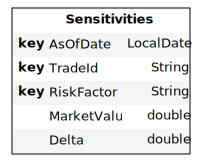

In [8]:
cube.schema

Let's do a quick visualization to view the Market Value and Delta measures from the initial source file.  
The following command serves for a quick inline atoti visualization:

In [9]:
session.visualize("Initial risk data")

Open the notebook in JupyterLab with the atoti extension installed and enabled to start editing this widget.

Let's download portfolio from the previous business day into the same folder

In [10]:
wget.download(
    "https://data.atoti.io/notebooks/real-time-risk/static-input-files/risk_data_previous_cob.csv",
    "./dynamic-input-files",
)

100% [................................................................................] 1254 / 1254

'./dynamic-input-files/risk_data_previous_cob (1).csv'

In [11]:
session.visualize("Risk data after uploading 8th of July")

Open the notebook in JupyterLab with the atoti extension installed and enabled to start editing this widget.

# Refining the cube

The `create_cube` command triggered the creation of default measures and dimensions, which can be further customized and refined, we are creating variables to access their collections:

In [12]:
m = cube.measures
lvl = cube.levels
h = cube.hierarchies

The following cell **hides the created measures** for the mean:

In [13]:
m["MarketValue.MEAN"].visible = False
m["Delta.MEAN"].visible = False

The next cell is making the date dimension slicing, so that there's no summation across dates:

In [14]:
h["AsOfDate"].slicing = True

The next cell will sort dates in desc order:

In [15]:
lvl["AsOfDate"].comparator = tt.comparator.DESC

Please refer to the atoti documentation to learn about other ways to refine your cube, in particular about creating custom aggregation functions: [New measures](https://docs.atoti.io/0.4.1/tutorial/01-Basics.html#New-measures).

### 2. Real-time via datastore `append` function

To implement real-time instrument prices, we’ll be pushing new values using the datastore `append` command. In the following cell, we're creating the `market_data_store`. As you probably noticed, we are not setting the `watch` parameter as in the previous example, as it defaults to `False`:

In [16]:
market_data_store = session.read_csv(
    "s3://data.atoti.io/notebooks/real-time-risk/static-input-files/market_data.csv",
    keys=["AsOfDate", "Instrument"],
    store_name="Market_Data_Store",
    types={
        "AsOfDate": tt.type.LOCAL_DATE,
        "Instrument": tt.type.STRING,
        "Quote": tt.type.DOUBLE,
    },
)

Displaying the current state of the `market data store`:

In [17]:
market_data_store.head(5)

Quote
AsOfDate   Instrument        
2020-07-08 OXY          16.23
           MSFT        214.00
           AAPL        380.00

At any time, we can use the `append` command to inject new records, for example:

In [18]:
market_data_store.append(("2020-07-09", "AAPL", 381.0))
market_data_store.append(("2020-07-09", "OXY", 16.8))
market_data_store.append(("2020-07-09", "MSFT", 215.0))
market_data_store.head(5)

Quote
AsOfDate   Instrument        
2020-07-08 OXY          16.23
           MSFT        214.00
           AAPL        380.00
2020-07-09 AAPL        381.00
           OXY          16.80

This `join` will link the `sensitivities_store` and the `market_data_store` and allow displaying sensitivities next to quotes.

In [19]:
sensitivities_store.join(
    market_data_store, mapping={"AsOfDate": "AsOfDate", "RiskFactor": "Instrument"}
)

Current state of the data model can be visualized by the following command:

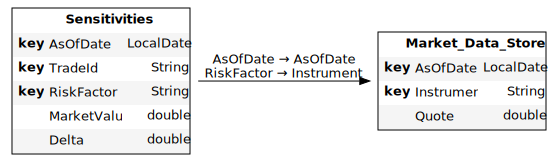

In [20]:
cube.schema

In [21]:
m["Quote.VALUE"] = tt.value(market_data_store["Quote"])

In [22]:
session.visualize("Quotes next to Deltas and MarketValues")

Open the notebook in JupyterLab with the atoti extension installed and enabled to start editing this widget.

# Enriching risk data - trade attributes and multi-level book structure

To facilitate the analysis, we can enrich the metrics with additional attributes such as risk factors, regions, sectors, trade typologies, etc. 

In this example, we are adding trade attribute data and linking trades to a multi-level booking hierarchy. 

In [23]:
trade_attributes = session.read_csv(
    "s3://data.atoti.io/notebooks/real-time-risk/static-input-files/trade_attributes.csv",
    types={"TradeId": tt.type.STRING, "Strike": tt.type.STRING},
    keys=["TradeId"],
    store_name="Trade_Attributes",
)

sensitivities_store.join(trade_attributes)

In [24]:
book_hierarchy = session.read_pandas(
    pd.DataFrame(
        data={
            "Book": [
                "EQ_VOL_HED",
                "EQ_STRUCT",
                "EQ_LARG_DM",
                "EQ_WAREHOU",
                "EQ_SMAL_EM",
            ],
            "Desk": [
                "Structuring",
                "Structuring",
                "Equity Trading",
                "Equity Trading",
                "Equity Trading",
            ],
            "Business Unit": [
                "Equities",
                "Equities",
                "Equities",
                "Equities",
                "Equities",
            ],
        }
    ),
    keys=["Book"],
    store_name="Book_Hierarchy",
)

trade_attributes.join(book_hierarchy)

Current state of the data model:

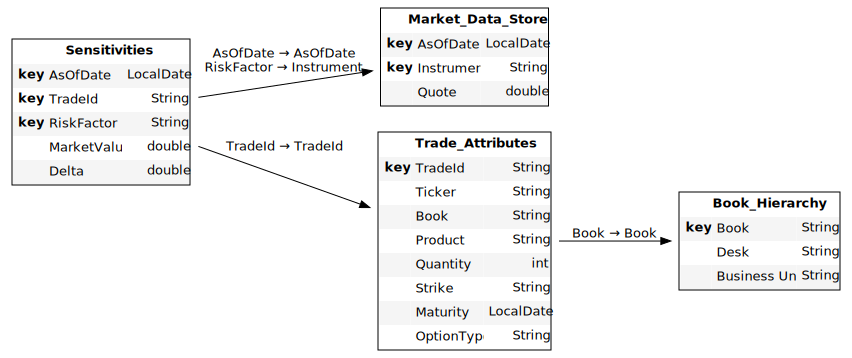

In [25]:
cube.schema

In fact, the **attributes do not have to be static**. They can be refreshed as soon as data arrives. For example, by adding a “Trade status” into the `trade_attributes` store I could use it to tag trades as “Terminated” and filter them out from the view.

In the following cell, we are creating a hierarchy representing ogranisational structure:

In [26]:
h["Portfolio Structure"] = {
    "Business Unit": lvl["Business Unit"],
    "Desk": lvl["Desk"],
    "Book": lvl["Book"],
}

We can expand and collapse data along the multi-level hierarchy:

In [27]:
session.visualize()

Open the notebook in JupyterLab with the atoti extension installed and enabled to start editing this widget.

Current data model schema:

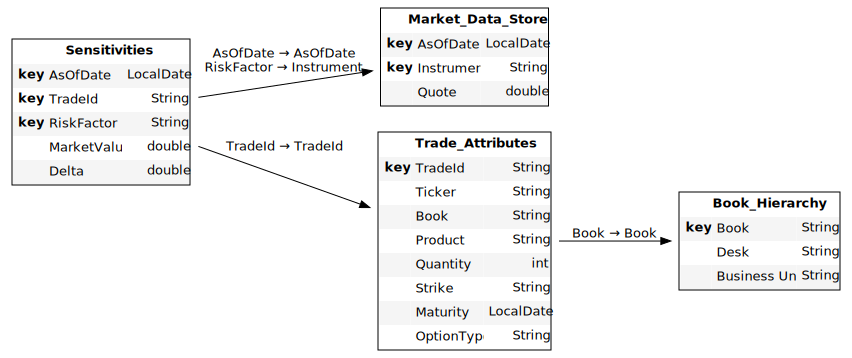

In [28]:
cube.schema

# Start real-time sources

In the following section I'm emulating a market data feed, which is triggering portfolio repricing. 

A pricing library is mocked up by a function computing greeks using a QuantLib implementation of the Black-Scholes formulae. 

In [29]:
## Uncomment these lines if you wish to install QuantLib
import sys
!{sys.executable} -m pip install QuantLib

In [30]:
from pricing_engine_emulator import reprice_portfolio, reprice_trade

Open a dashboard via this link - you will see the most recent portfolio summary. The widgets are switched to the "real-time" query mode, but the data is not updating just yet. Run the subsequent cells to "start" the real-time and watch cells blinking.

In [31]:
session.url + "/#/dashboard/8b4"

'http://localhost:54223/#/dashboard/8b4'

To simulate the market data updates, I am going to replay simulated historical stock prices. This code snippet downloads historical data and pushes new tick updates into a queue. The publisher waits for the `should_publish` event, which is triggered in the subsequent cells.

In [32]:
import queue
import threading

should_publish = threading.Event()

spot_update_queue = queue.Queue()
tick_data = pd.read_csv(
    "https://data.atoti.io/notebooks/real-time-risk/static-input-files/stock_price_tick_data.csv", index_col="AsOfDate", parse_dates=["AsOfDate"]
)
positions = pd.read_csv("https://data.atoti.io/notebooks/real-time-risk/static-input-files/trade_attributes.csv", parse_dates=["Maturity"])


def start_spot_publisher():
    # The publisher is replaying tick_data.
    # It waits for the should publish event (see subsequent cells to trigger).

    current_time = -1
    for idx, row in tick_data.iterrows():
        next_time = idx
        if current_time != -1:
            dt = (next_time - current_time).total_seconds() / 100.0
            time.sleep(dt)
        current_time = idx
        print("\rawaiting for publishing update " + str(idx), end="")
        should_publish.wait()
        print("\rpublishing update " + str(idx), end="")
        spot_update_queue.put((idx, row.to_dict()))
    spot_update_queue.join()
    print("All work completed")


def start_spot_update_listener():
    print("Real time updates started")
    while True:
        calc_date, spot_prices_by_ticker = spot_update_queue.get()

        """
        As discussed above, I'm illustrating the "reactive" data store 
        by configuring it with the parameter watch set to True.
        With the following code I'm updating the file on disc:
        """
        reprice_portfolio(spot_prices_by_ticker, positions, calc_date).to_csv(
            "dynamic-input-files/risk_data.csv", index=False
        )

        """
        The second example of real-time implementation - is injecting the data 
        directly into a datastore.
        With the following code I'm appending the new stock prices to the market data store.
        """
        for i in list(spot_prices_by_ticker.items()):
            if not pd.isnull(i[1]):
                clear_output(wait=True)
                print((calc_date.strftime("%Y-%m-%d"), i[0], i[1]))
                market_data_store.append((calc_date.strftime("%Y-%m-%d"), i[0], i[1]))

        spot_update_queue.task_done()


listener_thread = threading.Thread(target=start_spot_update_listener, daemon=True)
publisher_thread = threading.Thread(target=start_spot_publisher, daemon=True)


Run the next cell to start the real-time feeds - and see the cells in the dashboards blinking if then contributing data changes.

In [33]:
publisher_thread.start()
listener_thread.start()
# start publishing
should_publish.set()

publishing update 2020-07-09 13:30:007-09 13:30:00Real time updates started


In [34]:
# pause publishing
should_publish.clear()

('2020-07-09', 'OXY', 16.37)


# 3. Kafka feed and a custom deserializer

The above real-time feeds are illustrating the file **watch** and the **append** command. Now let's have a quick look at enabling a **kafka feed** for a  datastore.

I'm using [Bitnami Docker Image for Kafka](https://hub.docker.com/r/bitnami/kafka/) to run kafka, as a first step I'm downloading the .yml:

```
curl -sSL https://raw.githubusercontent.com/bitnami/bitnami-docker-kafka/master/docker-compose.yml > docker-compose.yml
```

Then adding the following parameter to the kafka environment section in the docker-compose.yaml - this makes Kafka accessible from outside the container.


```    
    - KAFKA_ADVERTISED_LISTENERS=PLAINTEXT://127.0.0.1:9092
```

![Docker config](./img/docker-config.png)


Then I'm using docker-compose to launch kafka:

```
docker-compose up -d
```

And then creating a topic for trades:

```
docker exec -it real-time-risk_kafka_1 /opt/bitnami/kafka/bin/kafka-topics.sh --create --bootstrap-server 127.0.0.1:9092 --topic trades
```

Let's point the `trades_datastore` to the kafka feed. atoti will consume the arriving trades data, and the widgets will refresh automatically (need to toggle them to real-time mode - as described in the atoti for real-time section above)

For a complete list of the atoti's `load_kafka` parameters, please refer to the doc [load_kafka](https://docs.atoti.io/0.4.2/lib/atoti.html?highlight=kafka#atoti.store.Store.load_kafka). In this example, I will leave the defaults for the `batch_duration` and `consumer_config` and create a custom serializer - that will skip certain fields from the trade tickets.

In [35]:
# This serializer will pick up the trade attributes field from the trade message
def fetch_trade_attributes(record: str):
    obj = json.loads(record)
    fact = {}
    for column in trade_attributes.columns:
        fact[column] = obj[column] if column in obj.keys() else ""
    return fact


# This serializer will pick up market value from the trade message. It also populates RiskFactor from the Ticker field:
def fetch_sensitivities(record: str):
    obj = json.loads(record)
    fact = {}
    for column in sensitivities_store.columns:
        fact[column] = obj[column] if column in obj.keys() else ""
    fact["RiskFactor"] = obj["Ticker"]
    return fact

From atoti v0.5.0 onwards, we can import the `atoti_kafka` package to load real-time Kafka streams into atoti store.

In [36]:
import atoti_kafka

('2020-07-09', 'MSFT', 224.73)


The base store`sensitivities_store` and the `trade_attributes` will be populated from the same message, and the serializers defined above will pick the relevant fields.

In [37]:
trade_attributes.load_kafka(
    bootstrap_server="localhost:9092",
    topic="trades",
    group_id="atoti-trades-consumer",
    deserializer=atoti_kafka.create_deserializer(fetch_trade_attributes),
)

sensitivities_store.load_kafka(
    bootstrap_server="localhost:9092",
    topic="trades",
    group_id="atoti-risk-consumer",
    deserializer=atoti_kafka.create_deserializer(fetch_sensitivities),
)

('2020-07-09', 'AAPL', 390.03)


I'll be using python kafka module to push new trade events. In the next cell, I'm sending a first trade message.

In [38]:
# # Uncomment these lines if you wish to install kafka-python
import sys
!conda install  -c conda-forge --yes --prefix {sys.prefix} kafka-python

awaiting for publishing update 2020-07-09 13:31:00Collecting package metadata (current_repodata.json): ...working... done
Solving environment: ...working... done

# All requested packages already installed.



In [39]:
# using kafka python module to publish messages
from kafka import KafkaProducer

producer = KafkaProducer(
    value_serializer=lambda v: json.dumps(v).encode("utf-8"),
    bootstrap_servers=["127.0.0.1:9092"],
)

Run this cell and check in the dashboard that the "New_Trd_Test" has arrived - expected on top of the "Trades Blotter" table.

In [40]:
# Test trade
trd = {
    "AsOfDate": "2020-07-09",
    "TradeId": "New_Trd_Test",
    "Ticker": "OXY",
    "Book": "EQ_VOL_HED",
    "Product": "EQ_Option",
    "Quantity": 45,
    "Strike": -31.41249430583221,
    "Maturity": "2022-10-01",
    "OptionType": "put",
    "MarketValue": 89.43425919208067,
}

l = producer.send("trades", trd)

To see the messages, the following command can be run:
    
```
docker exec -it real-time-risk_kafka_1 /opt/bitnami/kafka/bin/kafka-console-consumer.sh --bootstrap-server localhost:9092 --topic trades --from-beginning
```

In the following cell, I'm creating a function that will generate random trades.

In [41]:
def generate_a_new_trade(id):

    # this function is generating trades data (random)

    trade = {
        "AsOfDate": "2020-07-09",
        "TradeId": "New_Trade_" + str(id),
        "Ticker": random.choice(["AAPL", "MSFT", "OXY"]),
        "Book": random.choice(
            ["EQ_LARG_DM", "EQ_SMAL_EM", "EQ_STRUCT", "EQ_VOL_HED", "EQ_WAREHOU"]
        ),
        "Product": "EQ_Option",
        "Quantity": random.randrange(-100, 100),
        "Strike": random.uniform(-100, 100),
        "Maturity": "2022-10-01",
        "OptionType": "put",
        "MarketValue": random.uniform(-100, 100),
    }

    print("A new trade generated:")
    print(json.dumps(trade, indent=4))

    return trade

Let's check that we can see updates in the real-time dashboard:

In [42]:
session.url + "/#/dashboard/8b4"

'http://localhost:54223/#/dashboard/8b4'

Run the following cell to publish a few new trades and see them appearing in the "Trades Blotter" widget

In [43]:
for i in range(20):
    new_trade = generate_a_new_trade(i)

    producer.send("trades", new_trade)
    print("Published.\n")
    time.sleep(1)
    clear_output(wait=True)

A new trade generated:
{
    "AsOfDate": "2020-07-09",
    "TradeId": "New_Trade_19",
    "Ticker": "MSFT",
    "Book": "EQ_STRUCT",
    "Product": "EQ_Option",
    "Quantity": 88,
    "Strike": -32.14371799076474,
    "Maturity": "2022-10-01",
    "OptionType": "put",
    "MarketValue": -4.9674461717037985
}
Published.

